2024-07-22 18:43:10.702952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[*********************100%%**********************]  3 of 3 completed

Epoch 1/10


85/85 - 4s - 52ms/step - loss: 0.0030
Epoch 2/10
85/85 - 3s - 30ms/step - loss: 1.3059e-04
Epoch 3/10
85/85 - 3s - 30ms/step - loss: 1.1440e-04
Epoch 4/10
85/85 - 3s - 30ms/step - loss: 1.4918e-04
Epoch 5/10
85/85 - 3s - 31ms/step - loss: 1.0883e-04
Epoch 6/10
85/85 - 3s - 30ms/step - loss: 1.1063e-04
Epoch 7/10
85/85 - 3s - 30ms/step - loss: 9.8254e-05
Epoch 8/10
85/85 - 3s - 30ms/step - loss: 9.4633e-05
Epoch 9/10
85/85 - 3s - 30ms/step - loss: 8.8479e-05
Epoch 10/10
85/85 - 3s - 30ms/step - loss: 8.6736e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
RMSE for AAPL: 151.835513693041


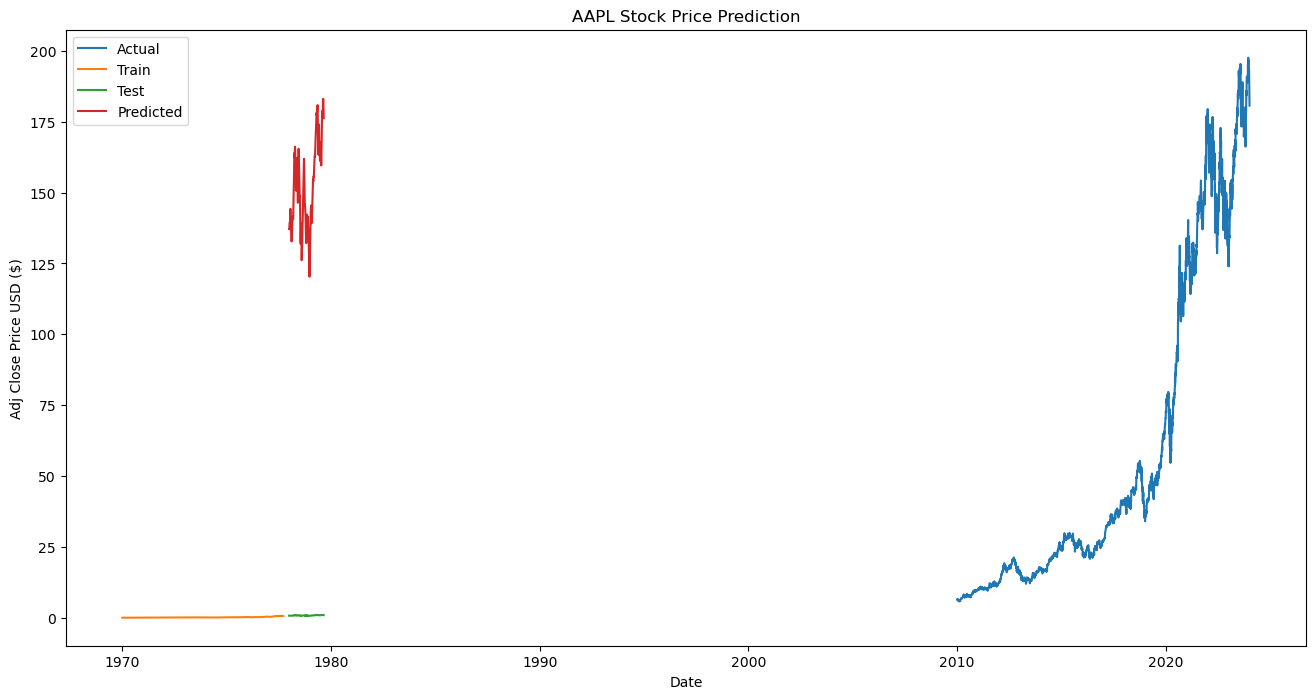

Epoch 1/10
85/85 - 5s - 55ms/step - loss: 0.0022
Epoch 2/10
85/85 - 3s - 30ms/step - loss: 1.5221e-04
Epoch 3/10
85/85 - 3s - 30ms/step - loss: 1.4368e-04
Epoch 4/10
85/85 - 3s - 30ms/step - loss: 1.3322e-04
Epoch 5/10
85/85 - 3s - 30ms/step - loss: 1.2777e-04
Epoch 6/10
85/85 - 3s - 30ms/step - loss: 1.3004e-04
Epoch 7/10
85/85 - 3s - 30ms/step - loss: 1.3126e-04
Epoch 8/10
85/85 - 3s - 30ms/step - loss: 1.1879e-04
Epoch 9/10
85/85 - 3s - 30ms/step - loss: 9.6654e-05
Epoch 10/10
85/85 - 3s - 30ms/step - loss: 9.2879e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
RMSE for GOOGL: 120.92037928887362


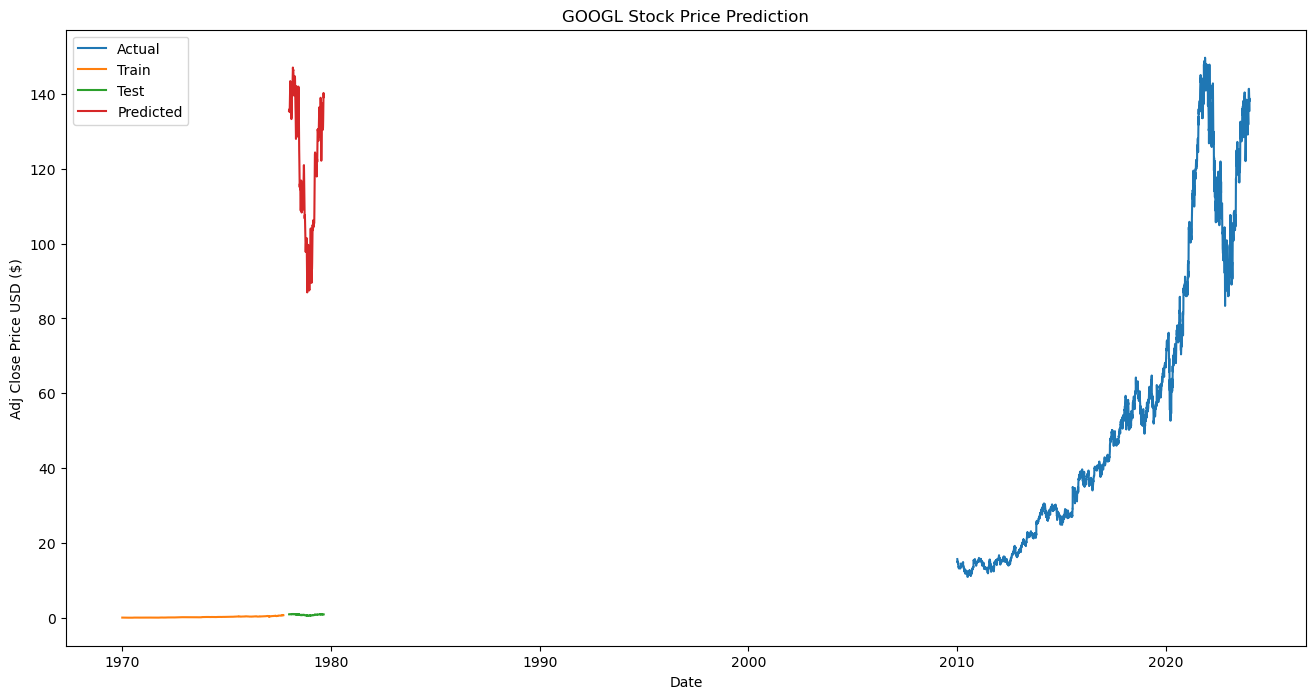

Epoch 1/10
85/85 - 4s - 51ms/step - loss: 0.0025
Epoch 2/10
85/85 - 3s - 30ms/step - loss: 7.6911e-05
Epoch 3/10
85/85 - 3s - 30ms/step - loss: 7.4277e-05
Epoch 4/10
85/85 - 3s - 30ms/step - loss: 7.0158e-05
Epoch 5/10
85/85 - 3s - 30ms/step - loss: 8.3402e-05
Epoch 6/10
85/85 - 3s - 30ms/step - loss: 6.9299e-05
Epoch 7/10
85/85 - 3s - 30ms/step - loss: 7.2585e-05
Epoch 8/10
85/85 - 3s - 30ms/step - loss: 7.0006e-05
Epoch 9/10
85/85 - 3s - 30ms/step - loss: 6.9154e-05
Epoch 10/10
85/85 - 3s - 30ms/step - loss: 7.1038e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
RMSE for MSFT: 280.58209814794924


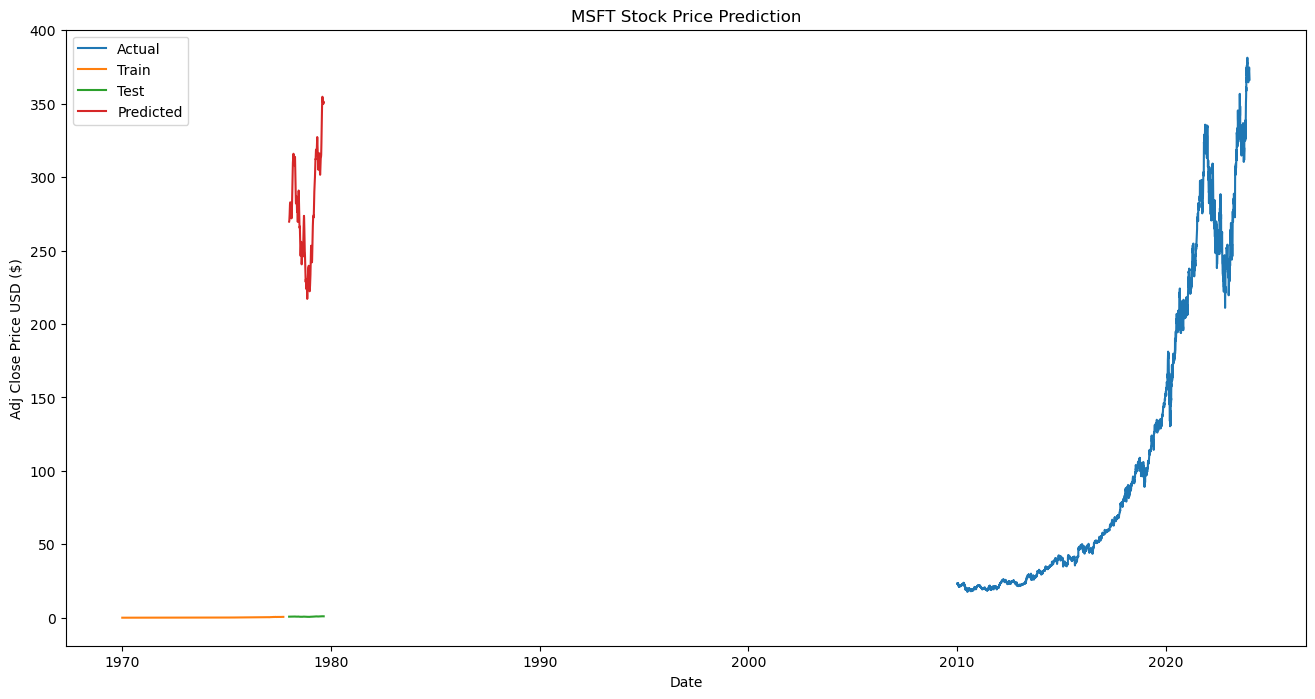

In [1]:
# Import necessary libraries
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib

# Function to download and preprocess data
def download_and_preprocess_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    data = data['Adj Close'].fillna(method='ffill')
    scalers = {ticker: MinMaxScaler(feature_range=(0, 1)) for ticker in tickers}
    scaled_data = pd.DataFrame({ticker: scalers[ticker].fit_transform(data[ticker].values.reshape(-1, 1)).flatten() for ticker in tickers})
    return data, scaled_data, scalers

# Function to create time-series dataset
def create_time_series(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to plot the data
def plot_data(data, train_data, test_data, predictions, title):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price USD ($)')
    plt.plot(data.index, data.values, label='Actual')
    plt.plot(train_data.index, train_data.values, label='Train')
    plt.plot(test_data.index, test_data.values, label='Test')
    plt.plot(test_data.index[-len(predictions):], predictions, label='Predicted')
    plt.legend()
    plt.show()

# Main function to execute the workflow
def main():
    tickers = ['AAPL', 'GOOGL', 'MSFT']
    start_date = '2010-01-01'
    end_date = '2024-01-06'
    time_step = 100
    epochs = 10
    batch_size = 32
    split_ratio = 0.8

    data, scaled_data, scalers = download_and_preprocess_data(tickers, start_date, end_date)
    for ticker in tickers:
        ticker_data = scaled_data[[ticker]]
        train_size = int(len(ticker_data) * split_ratio)
        train_data = ticker_data[:train_size]
        test_data = ticker_data[train_size:]

        X_train, y_train = create_time_series(train_data.values, time_step)
        X_test, y_test = create_time_series(test_data.values, time_step)

        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        model = build_model((X_train.shape[1], 1))
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

        predictions = model.predict(X_test)
        predictions = scalers[ticker].inverse_transform(predictions)

        # Align the length of test data and predictions
        y_test_actual = test_data.values[time_step:]
        
        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
        print(f'RMSE for {ticker}: {rmse}')

        plot_data(data[ticker], train_data[ticker], test_data[ticker].iloc[time_step:], predictions, f"{ticker} Stock Price Prediction")

        # Save the model and scaler
        model.save(f'{ticker}_stock_price_model.keras')
        joblib.dump(scalers[ticker], f'{ticker}_scaler.pkl')

if __name__ == "__main__":
    main()
